In [5]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

In [6]:
###add the extension functions notebook
%run pandas-missing-extension.ipynb

## Config of the general aspect of the graphs

In [7]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## Import Data

In [8]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df.head()

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973


In [9]:
nhanes_raw=(
    nhanes.load.load_NHANES_data(year='2017-2018')
    .clean_names(case_type='snake')
)
nhanes_raw.head()

,general_health_condition,ever_breastfed_or_fed_breastmilk,age_stopped_breastfeedingdays,age_first_fed_formuladays,age_stopped_receiving_formuladays,age_started_other_foodbeverage,age_first_fed_milkdays,type_of_milk_first_fed_whole_milk,type_of_milk_first_fed2_milk,type_of_milk_first_fed1_milk,...,days_smoked_cigs_during_past30_days,avg_cigarettesday_during_past30_days,tried_to_quit_smoking,times_stopped_smoking_cigarettes,how_long_were_you_able_to_stop_smoking,unit_of_measure_dayweekmonthyear_2_smq,current_selfreported_height_inches,current_selfreported_weight_pounds,tried_to_lose_weight_in_past_year,times_lost10_lbs_or_more_to_lose_weight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Proceess NHANES Data

In [10]:
nhanes_df=(
    nhanes_raw
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':'age',
            'current_selfreported_height_inches': 'height',
            'current_selfreported_weight_pounds':'weight',
            'doctor_told_you_have_diabetes' : 'diabetes',
            '60_sec_pulse30_sec_pulse2' : 'pulse',
            'total_cholesterol_mgdl': 'total_cholesterol'
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline': np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset=['diabetes'],
        how='any'
    )
    .transform_column(
        column_name='diabetes',
        function= lambda s: s.astype(int),
        elementwise=False
    )
)

In [11]:
nhanes_df.head()

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male


In [12]:
#nhanes_df.cholesterol.unique()
#df.weight.unique()
#nhanes_df.diabetes.unique()
#nhanes_df.describe()

## Study of missing values

<AxesSubplot:>

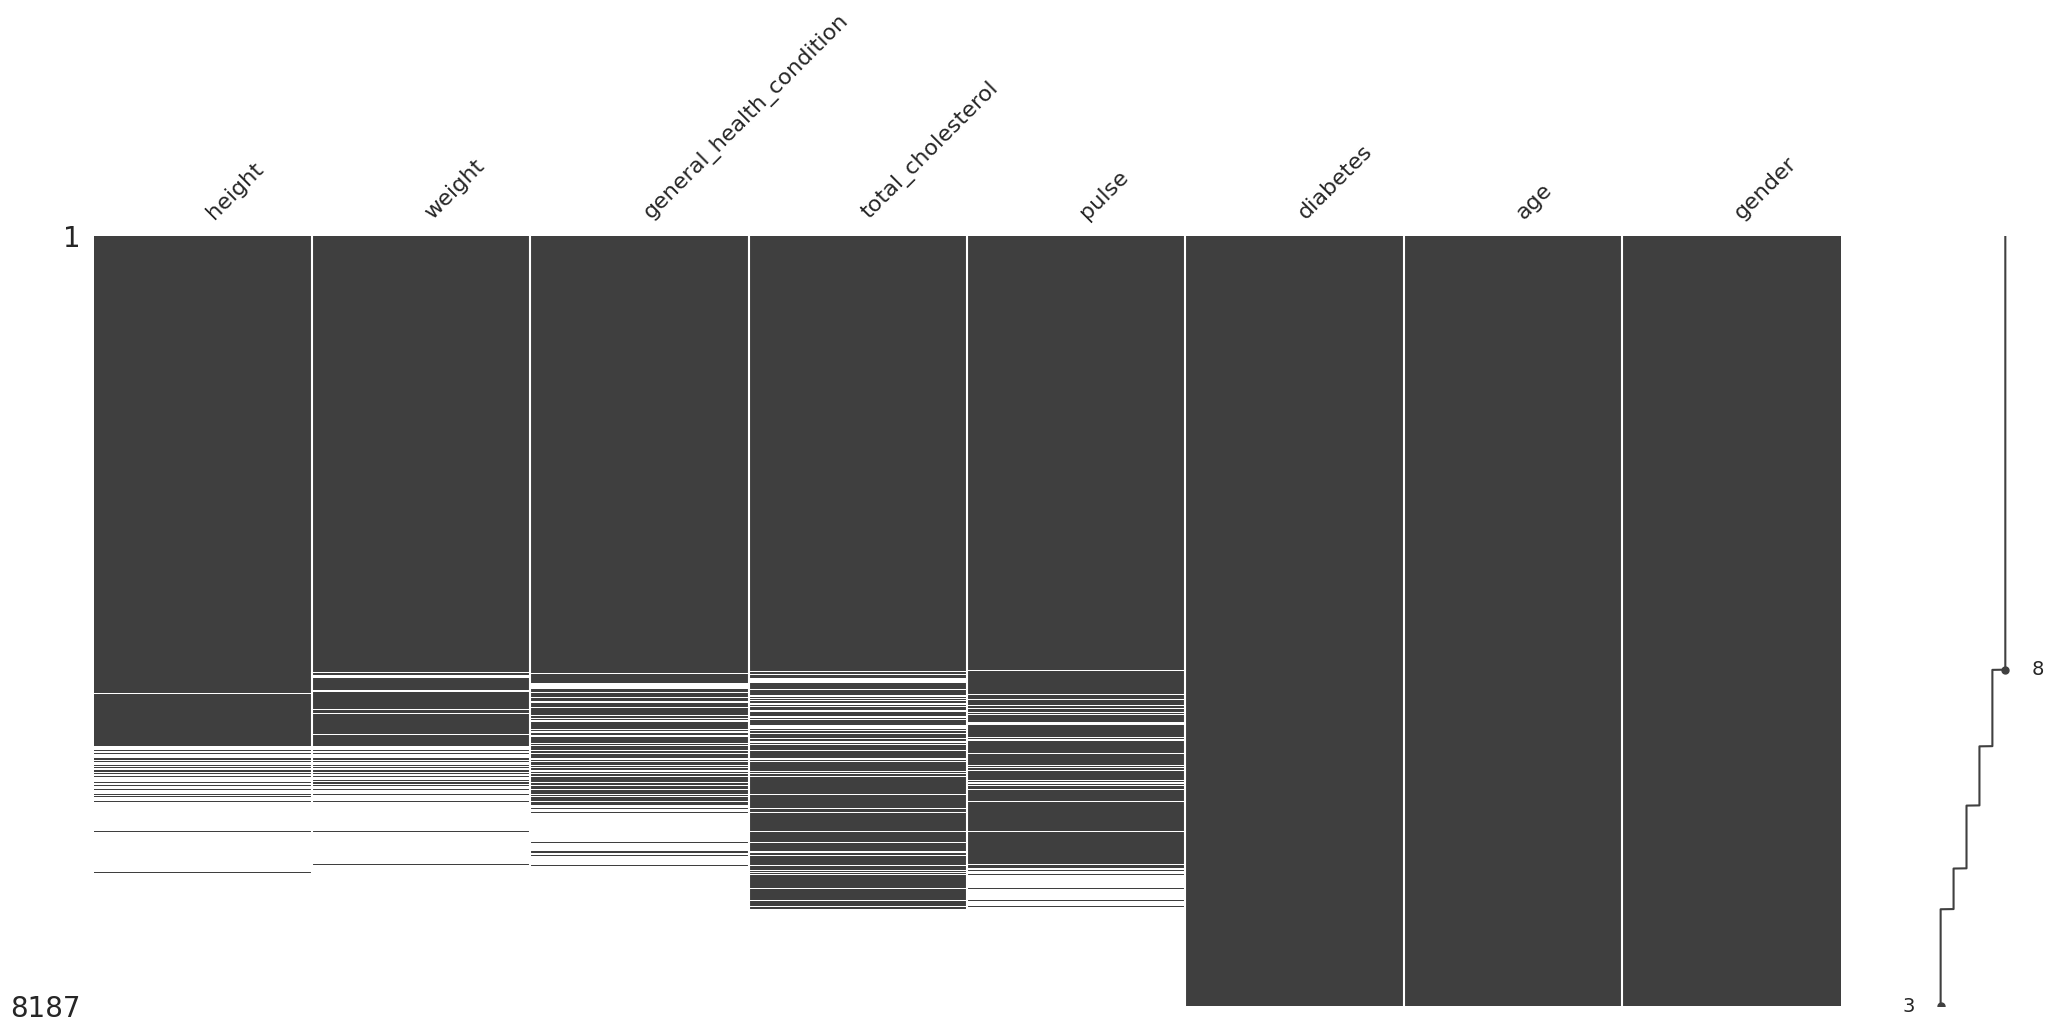

In [13]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .pipe(
        missingno.matrix,sort='descending'
    )
)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

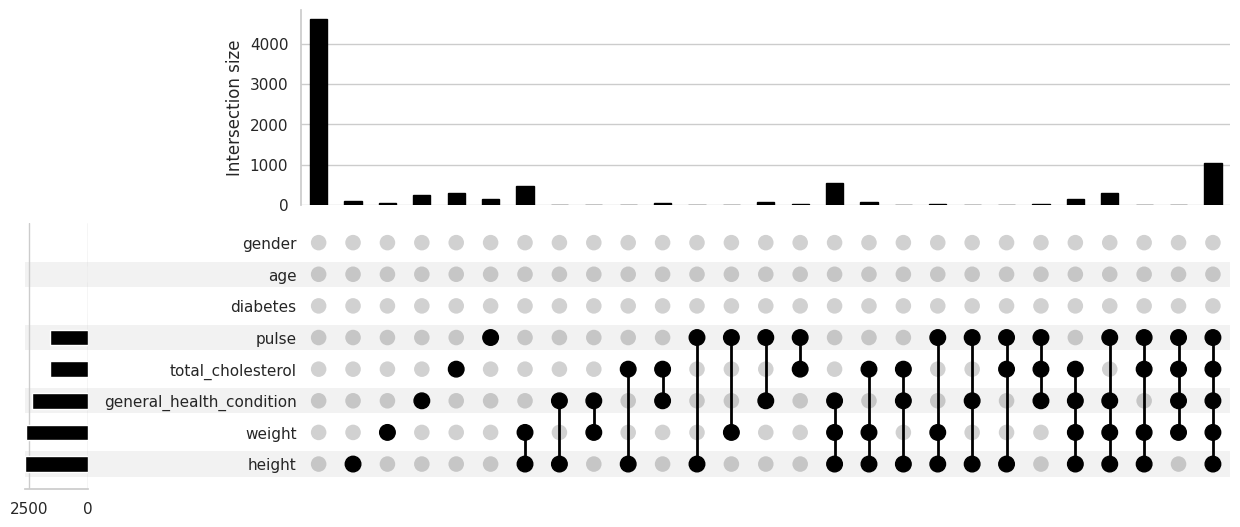

In [14]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
)

<p> We sahould eliminate all the records at the righgt of the chart. Those records has too many variables missing at the same time.  </p>

<AxesSubplot:>

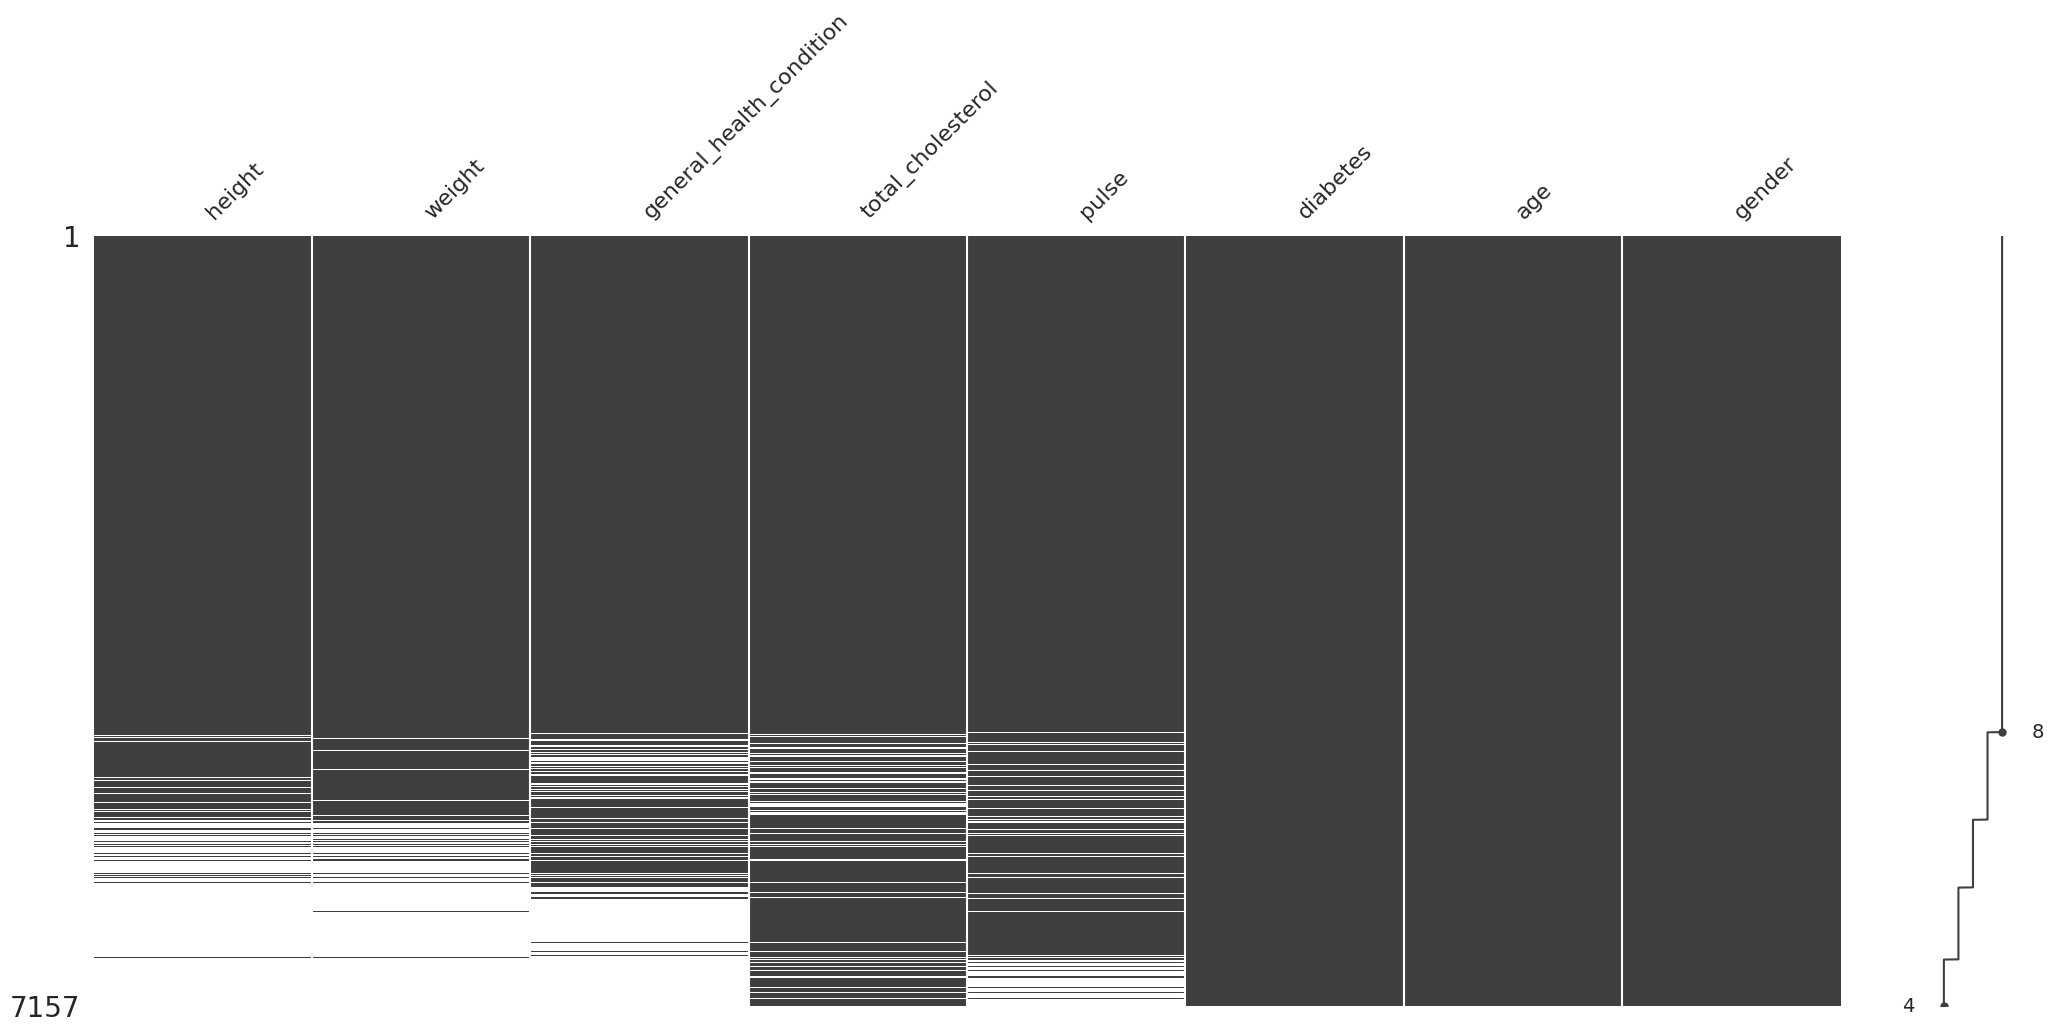

In [15]:
(
    nhanes_df
    .dropna(
        subset=['pulse','total_cholesterol','general_health_condition','weight','height'],
        how='all'
    )
    .missing.sort_variables_by_missingness()
    .pipe(
        missingno.matrix,sort='descending'
    )
)

## Eliminate missing values

In [16]:
nhanes_df=(
    nhanes_df
    .dropna(
        subset=['pulse','total_cholesterol','general_health_condition','weight','height'],
        how='all'
    )
)

## Evaluación del mecanismo de valores faltantes mediante la prueba *t-test*

In [17]:
female_weight,male_weight=(
    nhanes_df
    .select_columns('gender','weight')
    .transform_column(
        'weight',
        lambda x:x.isna(),
        elementwise=False
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df: (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

scipy.stats.ttest_ind(
    a=female_weight,
    b=male_weight,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

In [18]:
nhanes_df.age.describe()

count    7157.000000
mean       40.029761
std        23.159479
min         6.000000
25%        17.000000
50%        39.000000
75%        61.000000
max        80.000000
Name: age, dtype: float64

In [19]:
nhanes_df['age_category']=(
    np.where(
        nhanes_df.age>40,'Mayores','Menores'
    )
)

/tmp/ipykernel_629/1160178789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nhanes_df['age_category']=(


In [20]:
nhanes_df.head()

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender,age_category
SEQN,,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female,Mayores
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male,Menores
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male,Menores
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female,Mayores
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male,Mayores


In [21]:
high_age_height, low_age_height = (
    
    nhanes_df
    .select_columns('height','age_category')
    .transform_column(
        'height',
        lambda d: d.isna(),
        elementwise=False
    )
    .groupby('age_category')
    .height
    .pipe(
        lambda df: (
            df.get_group('Mayores'),
            df.get_group('Mayores')
        )
    )
    
)

scipy.stats.ttest_ind(
    a=high_age_height,
    b=low_age_height,
    alternative='two-sided'
)

Ttest_indResult(statistic=0.0, pvalue=1.0)

In [22]:
female_height,male_height=(
    nhanes_df
    .select_columns('gender','height')
    .transform_column(
        'height',
        lambda x:x.isna(),
        elementwise=False
    )
    .groupby('gender')
    .height
    .pipe(
        lambda df: (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

scipy.stats.ttest_ind(
    a=female_height,
    b=male_height,
    alternative='two-sided'
)

Ttest_indResult(statistic=-1.0441004739954949, pvalue=0.29647418035378503)

In [23]:
female_cholesterol,male_cholesterol=(
    nhanes_df
    .select_columns('gender','total_cholesterol')
    .transform_column(
        'total_cholesterol',
        lambda x:x.isna(),
        elementwise=False
    )
    .groupby('gender')
    .total_cholesterol
    .pipe(
        lambda df: (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

scipy.stats.ttest_ind(
    a=female_cholesterol,
    b=male_cholesterol,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.7000351630218239, pvalue=0.48392810483409965)

In [24]:
(
    nhanes_df
    .select_columns('weight','general_health_condition','gender')
    .assign(
        weight = lambda df: df.weight.isna().replace([True,False],['Missing','NotMissing'])
    )
    .groupby(['gender','general_health_condition','weight'],
             dropna=False,
             as_index=True)
    .size()
)

gender  general_health_condition  weight    
Female  Excellent                 Missing         65
                                  NotMissing     212
        Fair or                   Missing         42
                                  NotMissing     549
        Good                      Missing        113
                                  NotMissing    1102
        Poor?                     Missing          3
                                  NotMissing      94
        Very good                 Missing        103
                                  NotMissing     659
        NaN                       Missing        489
                                  NotMissing     234
Male    Excellent                 Missing         62
                                  NotMissing     273
        Fair or                   Missing         31
                                  NotMissing     508
        Good                      Missing        112
                                  NotMissing    1056
 

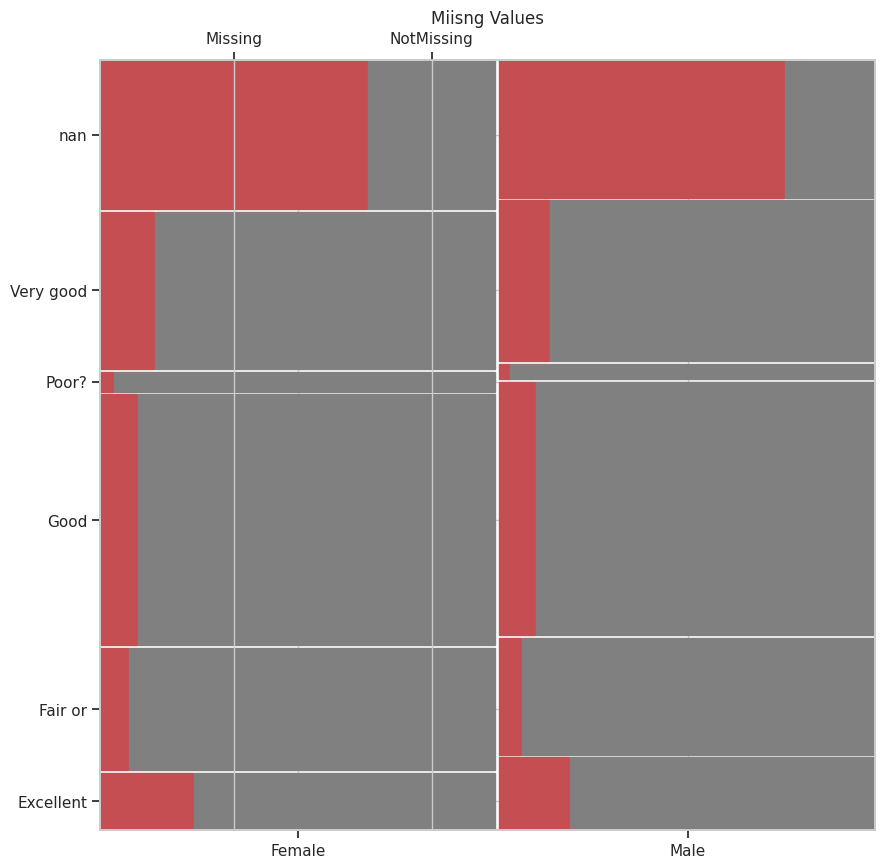

In [25]:
figf, ax = plt.subplots(figsize=(10,10))
(
    nhanes_df
    .select_columns('gender','general_health_condition','weight')
    .assign(
        weight = lambda df: df.weight.isna().replace([True,False],['Missing','NotMissing'])
    )
    .groupby(['gender','general_health_condition','weight'],
             dropna=False,
             as_index=True)
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key:{'color':'r' if 'Missing' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='Miisng Values',
            labelizer= lambda key:'',
            ax=ax
        )
    )
);

In [26]:
def missing_mosaic_plot(df,x_variable,y_variable,target_var):
    figf, ax = plt.subplots(figsize=(10,10))
    (
        df
        .select_columns(x_variable,y_variable,target_var)
        .assign(
            weight = lambda df: df[target_var].isna().replace([True,False],['Missing','NotMissing'])
        )
        .groupby([x_variable,y_variable,target_var],
                dropna=False,
                as_index=True)
        .size()
        .pipe(
            lambda df: mosaic(
                data=df,
                properties=lambda key:{'color':'r' if 'Missing' in key else 'gray'},
                horizontal=True,
                axes_label=True,
                title='Missing Values',
                labelizer= lambda key:'',
                ax=ax
            )
        )
    );

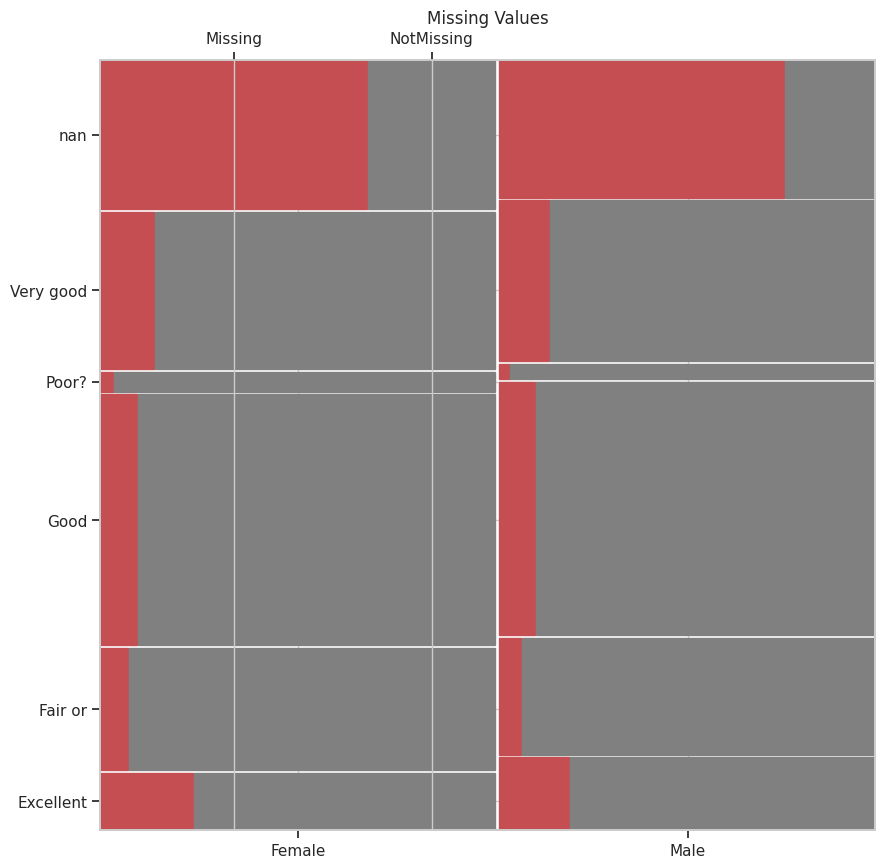

In [27]:
missing_mosaic_plot(nhanes_df,'gender','general_health_condition','weight')

In [28]:
df=nhanes_df.copy(deep=True)

## Ordinal Codification

<p>Litle exaple...</P>

In [29]:
encoder=sklearn.preprocessing.OrdinalEncoder()
X=[['Male'],['Female'],['Female']]
X

[['Male'], ['Female'], ['Female']]

In [30]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [31]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [32]:
encoder.inverse_transform([[1],[0],[0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

<p>with our DataFrame</P>

In [33]:
categorical_columns = df.select_dtypes(include=[object,'category']).columns

categorical_transformer=sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),categorical_columns),
    remainder='passthrough'
    )


In [34]:
#transformarion of the Dataset
df_num = (
    pd.DataFrame(
        categorical_transformer.fit_transform(df), 
        columns = categorical_transformer.get_feature_names_out(), 
        index = df.index 
    )
    .rename_columns(
        function = lambda x: x.split("__")[-1]
    )
)

df_num.head()

,general_health_condition,gender,age_category,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,
93705.0,2.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0


## Get Dummies vs OneHotEncoding

In [35]:
(
    df
    .select_columns('general_health_condition')
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


### Problemas:
- En caso de usar menos datos, nos se van a ver reflejados todos los valores.
- NO reconoce a los valores faltantes.

In [36]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),['gender']),
    (sklearn.preprocessing.OneHotEncoder(),['general_health_condition']),
    remainder='passthrough'
)


In [37]:
#transformarion of the Dataset
df_num2 = (
    pd.DataFrame(
        transformer.fit_transform(df), 
        columns = transformer.get_feature_names_out(), 
        index = df.index 
    )
    .rename_columns(
        function = lambda x: x.split("__")[-1]
    )
)

df_num2.head()

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age,age_category
SEQN,,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0,66.0,Mayores
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0,18.0,Menores
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0,13.0,Menores
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0,75.0,Mayores
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0,56.0,Mayores


In [38]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .inverse_transform(
        X=[[0,0,1,0,0,0]]
    )
)

array([['Good']], dtype=object)

## Imputación por media, mediana y moda

In [39]:
(
    df
    .transform_column(
        'height',
        lambda x: x.fillna(int(x.mean())),
        elementwise=False
        )
)

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender,age_category
SEQN,,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female,Mayores
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male,Menores
93707.0,66.0,NaN,Good,189.0,100.0,0,13.0,Male,Menores
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female,Mayores
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male,Mayores
...,...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male,Menores
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male,Mayores
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female,Mayores


## Imputación de un único valor (media, mediana, moda)

In [43]:
(
    df
    .transform_column(
        "height",
        lambda x: x.fillna(int(x.mean())),
        elementwise=False
    )
)

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender,age_category
SEQN,,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female,Mayores
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male,Menores
93707.0,66.0,NaN,Good,189.0,100.0,0,13.0,Male,Menores
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female,Mayores
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male,Mayores
...,...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male,Menores
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male,Mayores
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female,Mayores


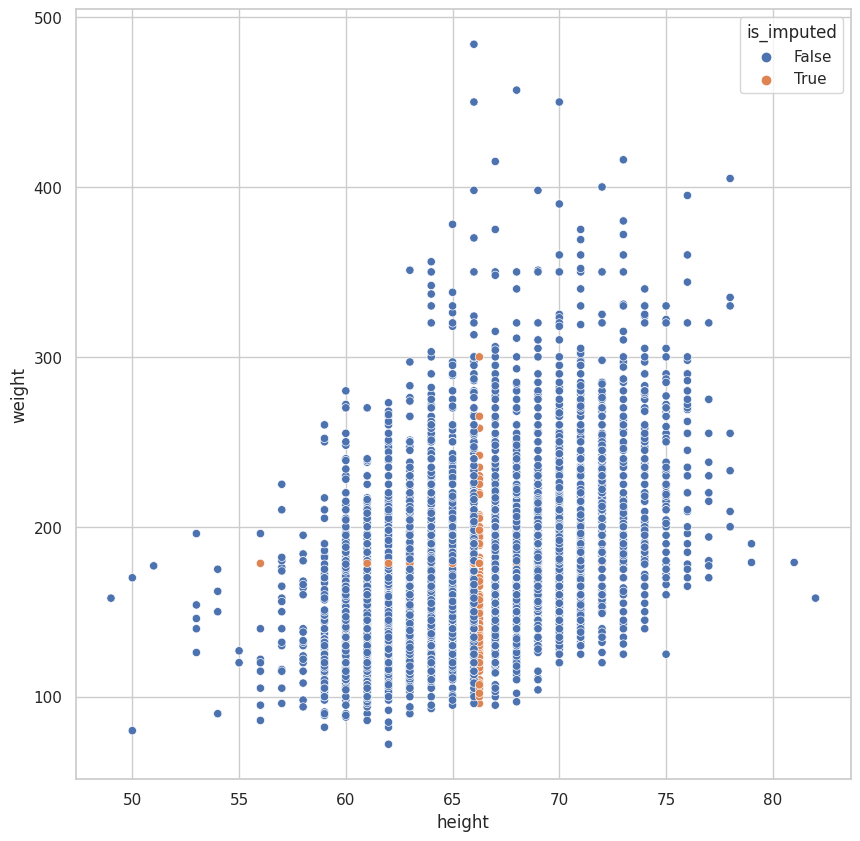

In [45]:

plt.figure(figsize=(10, 10))

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x="height", y="weight")
);

## Cómo se modifica la distribución?

<Figure size 1000x1000 with 0 Axes>

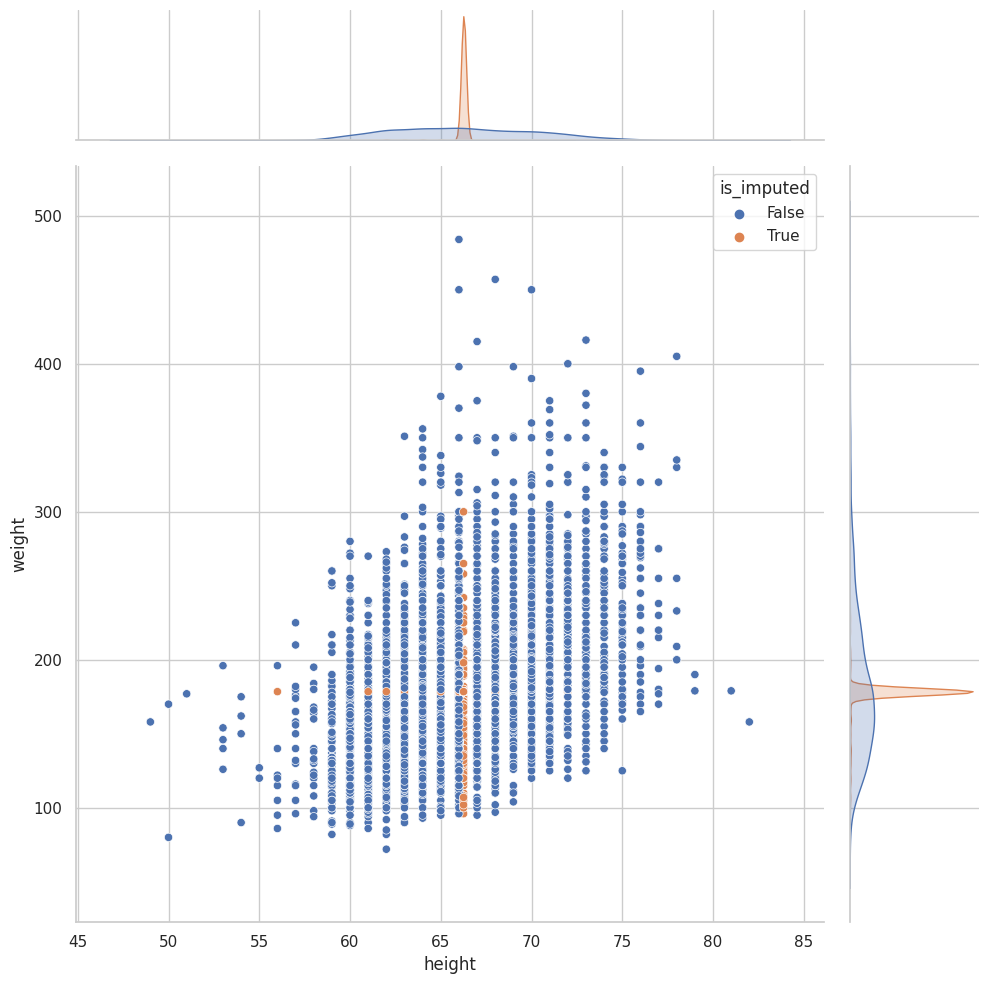

In [48]:

plt.figure(figsize=(10, 10))

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x="height",
                                     y="weight",
                                     show_marginal=True,
                                     height=10)
);

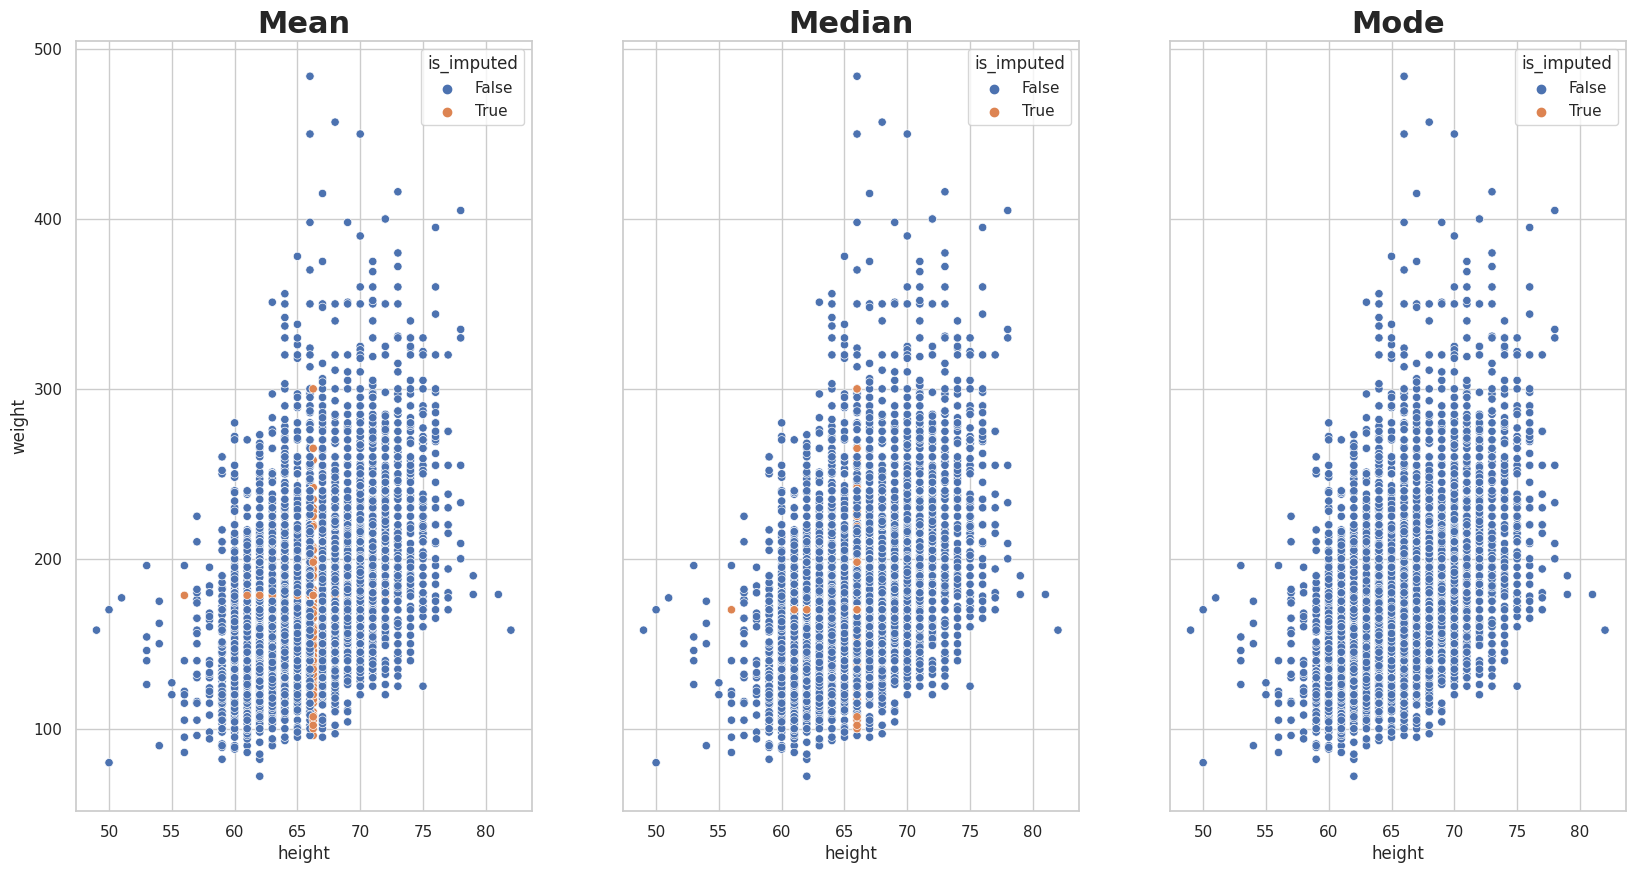

In [53]:
fig, ax = plt.subplots(1,3,figsize=(20,10), sharey=True)
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        # show_marginal = True,
        # height = 10,
        ax=ax[0]
    )
),
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        # show_marginal = True,
        # height = 10,
        ax=ax[1]
    )
),
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode()),
        weight = lambda df: df.weight.fillna(value = df.weight.mode())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        # show_marginal = True,
        # height = 10,
        ax=ax[2]
    )
),
ax[0].set_title("Mean", fontsize =22, fontweight='bold')
ax[1].set_title("Median", fontsize =22, fontweight='bold')
ax[2].set_title("Mode", fontsize =22, fontweight='bold');

## Imputación por llenado hacia atrás y hacia adelante

In [55]:
(
    df
    .select_columns('height','weight')
    # .fillna(
    #     method='ffill')
    .ffill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [56]:
(
    df
    .select_columns('height','weight')
    # .fillna(
    #     method='bfill')
    .bfill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


<p> Imputación a través de variables correlacionadas </p>

In [67]:
(
    df
    .select_columns('height','weight','gender','diabetes','general_health_condition')
    .sort_values(
        by=['gender','diabetes','general_health_condition','height'],
        ascending=True
    )
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
)

/tmp/ipykernel_629/1194980227.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df


,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,56.0,115.0,Female,0,Excellent
94187.0,59.0,130.0,Female,0,Excellent
95289.0,59.0,162.0,Female,0,Excellent
97967.0,59.0,130.0,Female,0,Excellent
99125.0,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96954.0,74.0,175.0,Male,1,NaN
97267.0,74.0,175.0,Male,1,NaN


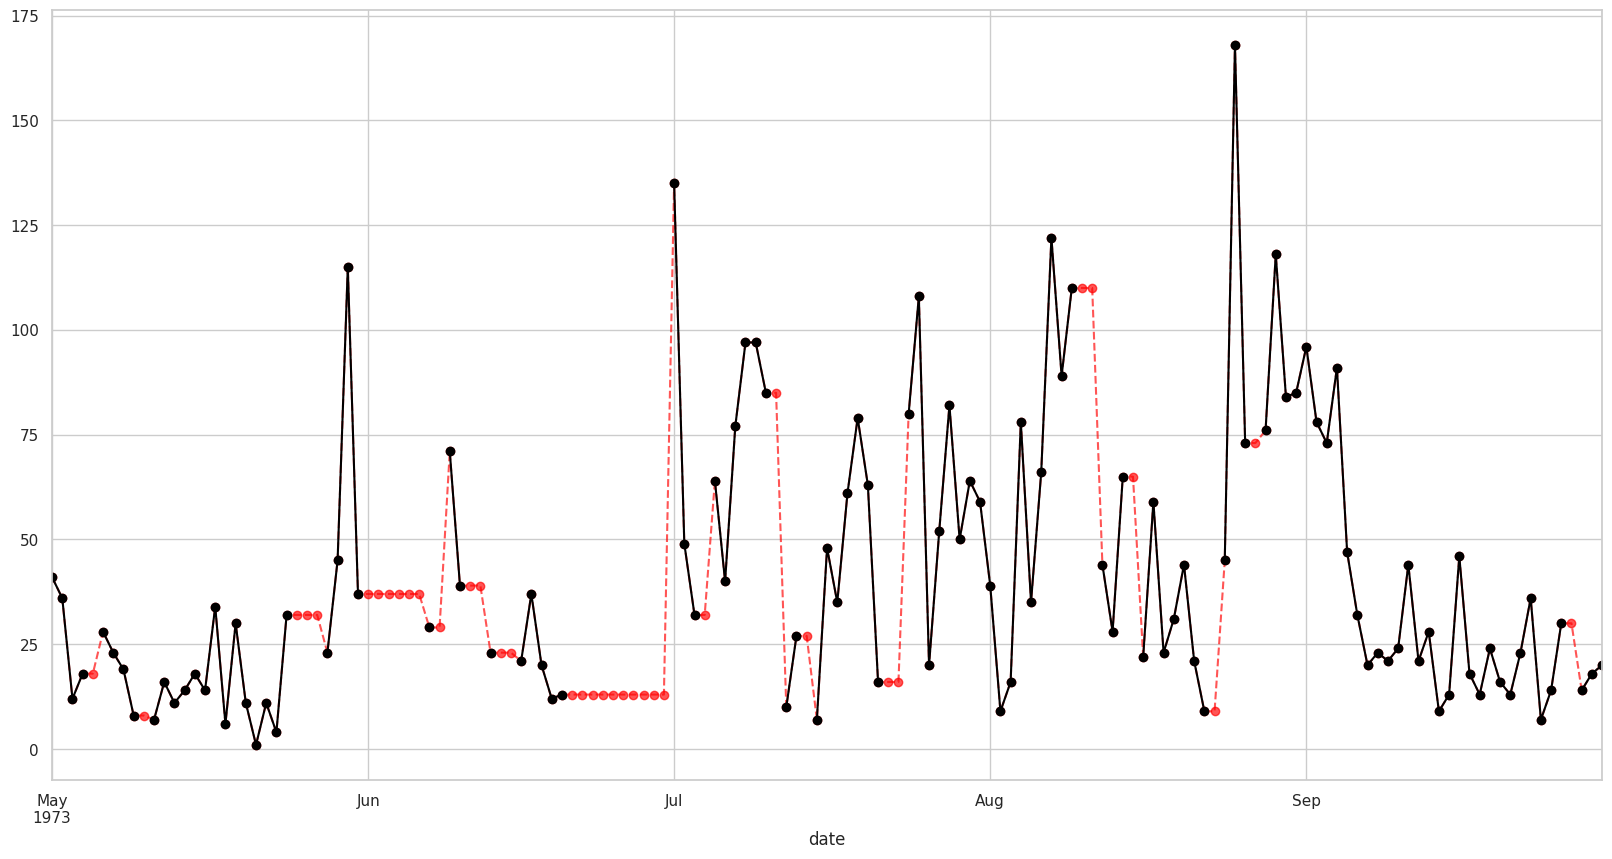

In [84]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.ffill().plot(color='red',marker='o',alpha=6/9,linestyle='dashed'),
            df.ozone.plot(color='black',marker='o')
        )
    )
);

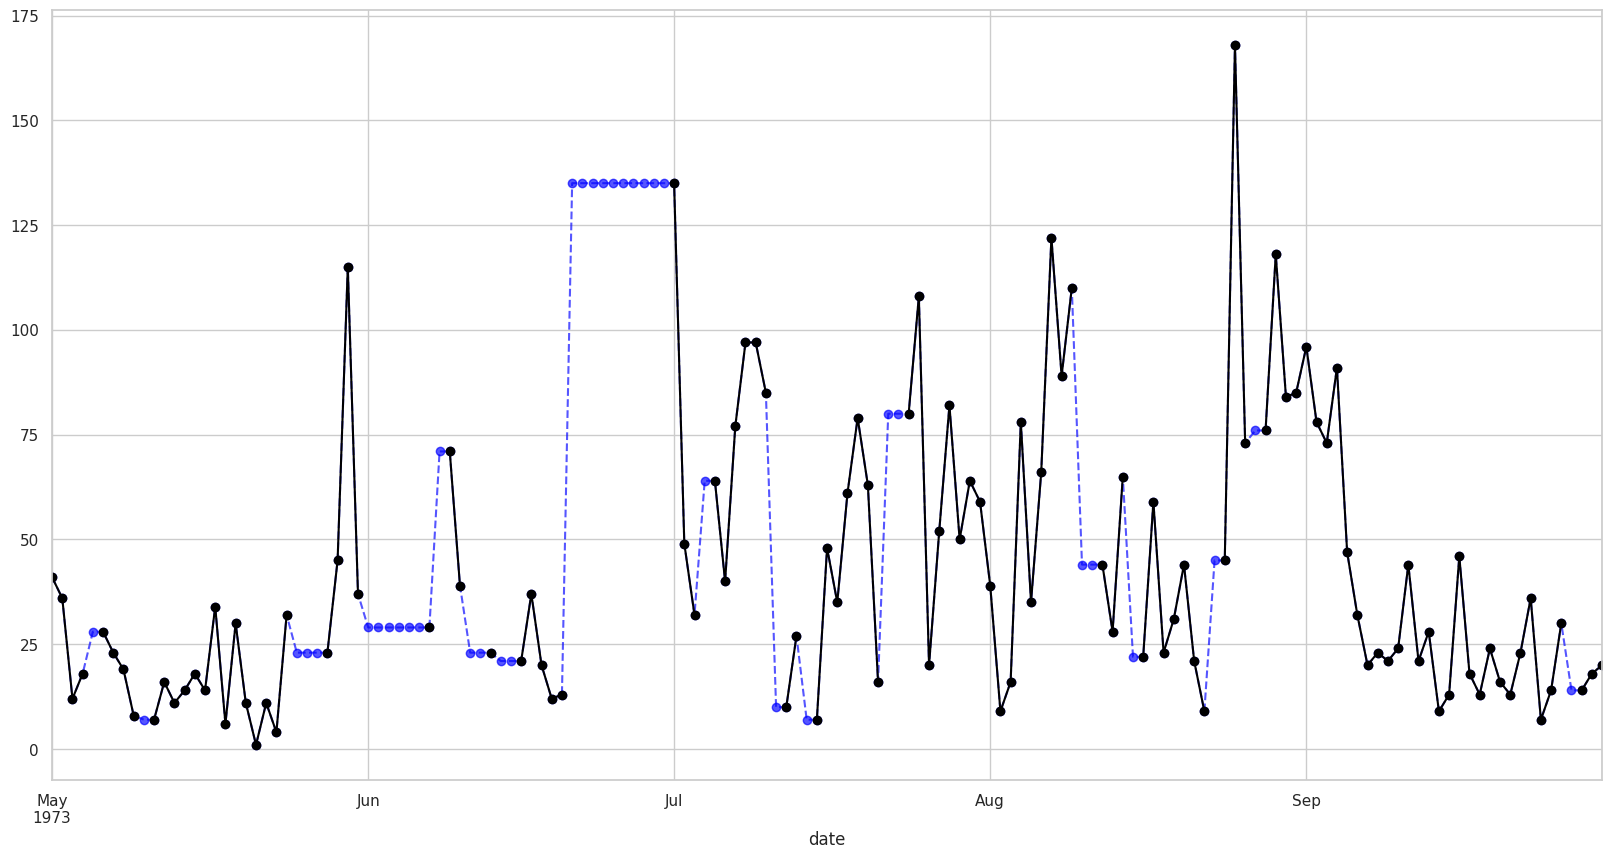

In [85]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.bfill().plot(color='blue',marker='o',alpha=6/9,linestyle='dashed'),
            df.ozone.plot(color='black',marker='o')
        )
    )
);

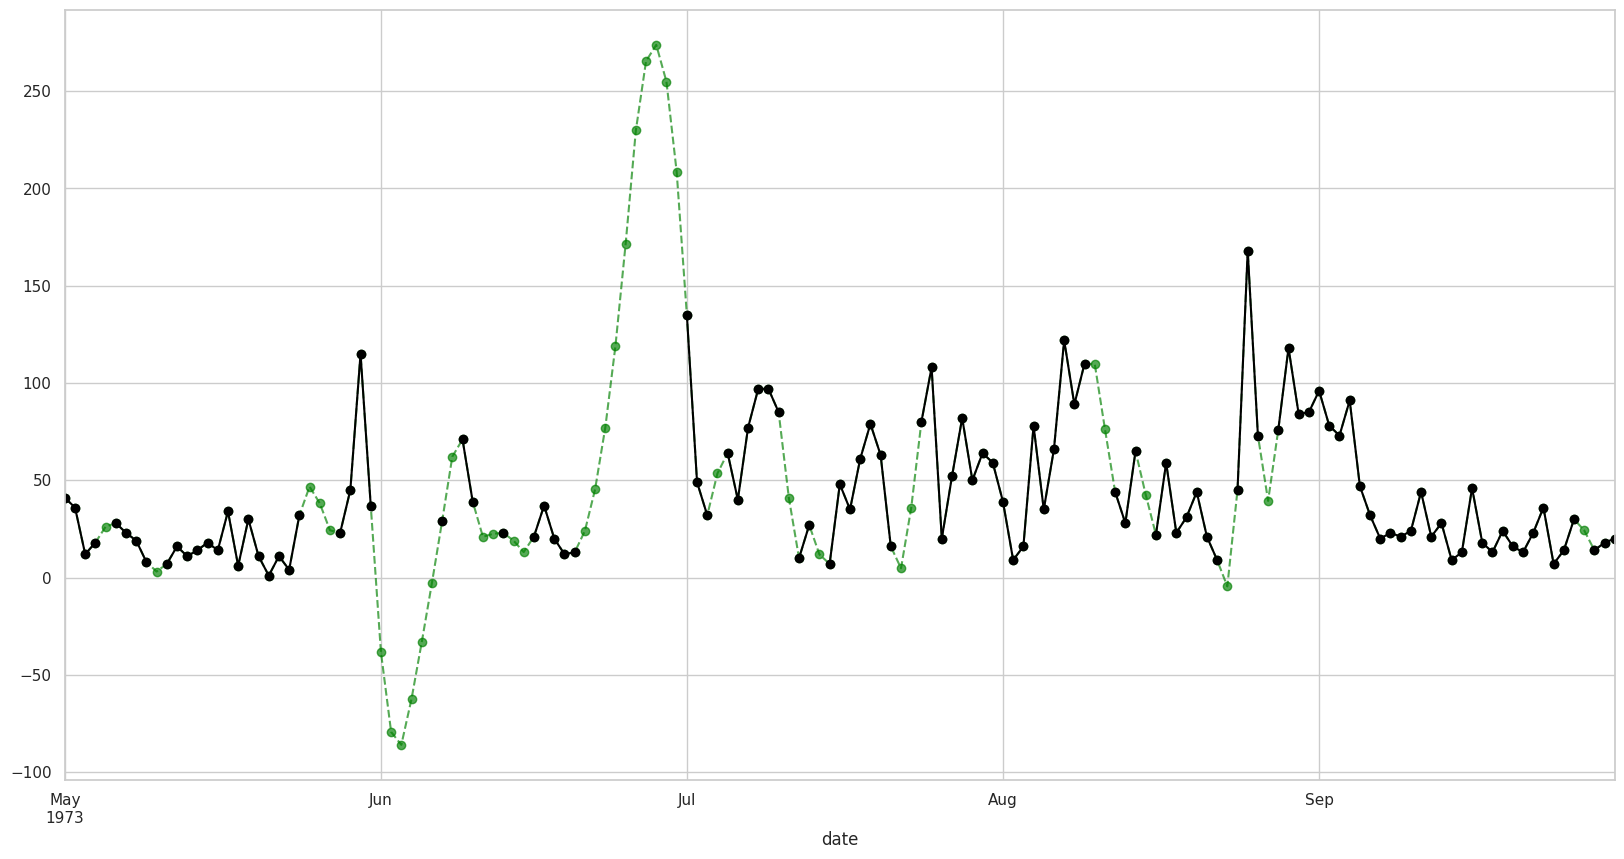

In [98]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.interpolate(method='quadratic').plot(color='green',marker='o',alpha=6/9,linestyle='dashed'),
            df.ozone.plot(color='black',marker='o')
        )
    )
);

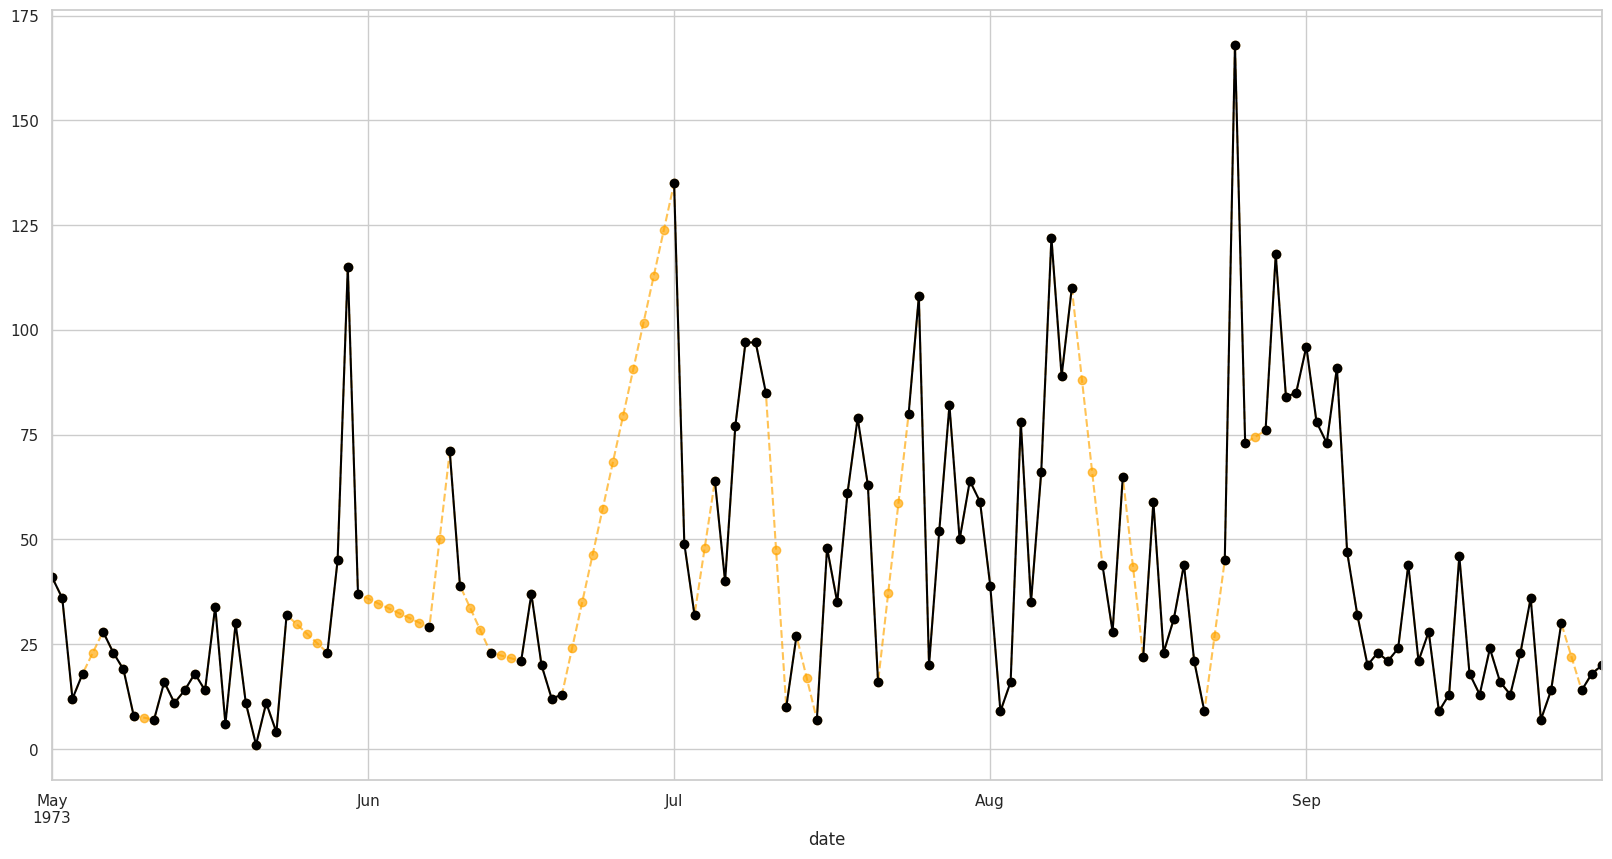

In [96]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.interpolate(method='linear').plot(color='orange',marker='o',alpha=6/9,linestyle='dashed'),
            df.ozone.plot(color='black',marker='o')
        )
    )
);